# The final model
 

## Model v2.0

In [1]:
model_name = f'3.33-v2.0'

In [2]:
import warnings

from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import load_data

_, augmented_data, test_data = load_data()

In [4]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [6]:
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [7]:
import dnns
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

create_dnn_model = dnns.create_model_MA01


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights(f'{model_name}.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[dnns.rmse]
    )
    return dnn


Epoch 1/100
4215/4215 - 8s - 2ms/step - loss: 11.6749 - rmse: 3.0937 - val_loss: 5.3509 - val_rmse: 2.0478
Epoch 2/100
4215/4215 - 5s - 1ms/step - loss: 5.9598 - rmse: 2.4094 - val_loss: 5.2622 - val_rmse: 2.0513
Epoch 3/100
4215/4215 - 5s - 1ms/step - loss: 5.6519 - rmse: 2.3458 - val_loss: 5.1960 - val_rmse: 2.0305
Epoch 4/100
4215/4215 - 5s - 1ms/step - loss: 5.4349 - rmse: 2.3003 - val_loss: 5.2712 - val_rmse: 2.0271
Epoch 5/100
4215/4215 - 5s - 1ms/step - loss: 5.2628 - rmse: 2.2626 - val_loss: 4.9935 - val_rmse: 1.9960
Epoch 6/100
4215/4215 - 5s - 1ms/step - loss: 5.1219 - rmse: 2.2327 - val_loss: 5.2701 - val_rmse: 2.0361
Epoch 7/100
4215/4215 - 5s - 1ms/step - loss: 5.0280 - rmse: 2.2113 - val_loss: 5.1222 - val_rmse: 2.0234
Epoch 8/100
4215/4215 - 5s - 1ms/step - loss: 4.9674 - rmse: 2.1981 - val_loss: 5.0692 - val_rmse: 2.0134
Epoch 9/100
4215/4215 - 5s - 1ms/step - loss: 4.8813 - rmse: 2.1787 - val_loss: 5.3507 - val_rmse: 2.0612
Epoch 10/100
4215/4215 - 5s - 1ms/step - loss

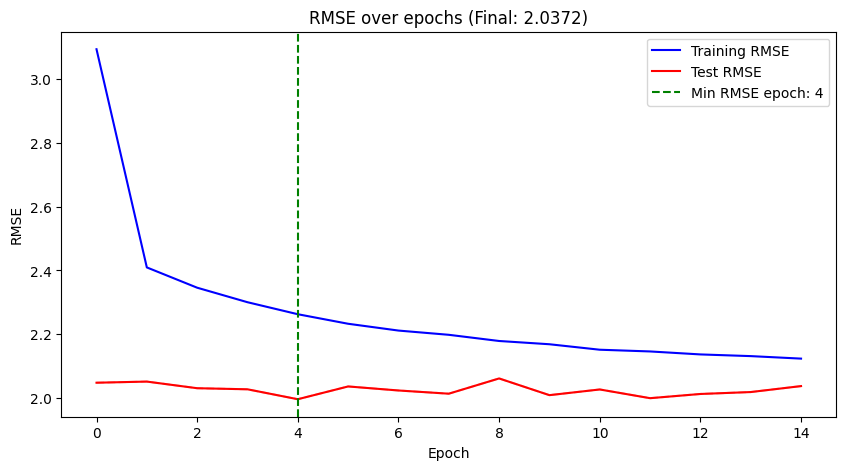

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge
from tensorflow.keras.callbacks import EarlyStopping
from model_performance_calculations import get_history_line_chart

# pretrain the DNN and use the weights in the stacking model
pretrained_dnn = create_dnn_model(X_train.shape[1])
pretrained_dnn.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=2,
    validation_split=0.2,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

history = pretrained_dnn.history.history
pretrained_dnn.save_weights(f'{model_name}.weights.h5')

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', HistGradientBoostingRegressor(max_iter=1000, max_depth=5, learning_rate=0.01)),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=5000, max_depth=5, learning_rate=0.01)),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('lasso', LassoLarsIC(criterion='bic', max_iter=5000)),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

get_history_line_chart([history]).show()

11:46:04 - Start training
11:46:04 - Calculate performance for hgb
11:46:04 - Split 1 - Model: hgb
11:46:04 - Fitting the model
11:46:35 - Predicting
11:46:40 - Calculating scores
11:46:40 - R^2: 0.6100186574895922, RMSE: 2.046819822286936, MAE: 1.5269598465704, MSE: 4.1894713849067236
11:46:40 - Split 2 - Model: hgb
11:46:40 - Fitting the model
11:47:12 - Predicting
11:47:13 - Calculating scores
11:47:13 - R^2: 0.6049237676468615, RMSE: 2.0413920446995104, MAE: 1.5377870284760011, MSE: 4.1672814801624485
11:47:13 - Split 3 - Model: hgb
11:47:13 - Fitting the model
11:47:53 - Predicting
11:47:54 - Calculating scores
11:47:54 - R^2: 0.6103071086219077, RMSE: 2.0459935486989993, MAE: 1.5287463843435096, MSE: 4.186089601317924
11:47:54 - Split 4 - Model: hgb
11:47:54 - Fitting the model
11:48:23 - Predicting
11:48:23 - Calculating scores
11:48:23 - R^2: 0.6092960325676904, RMSE: 2.0540394378283535, MAE: 1.534638731345659, MSE: 4.219078012154219
11:48:23 - Split 5 - Model: hgb
11:48:23 - F

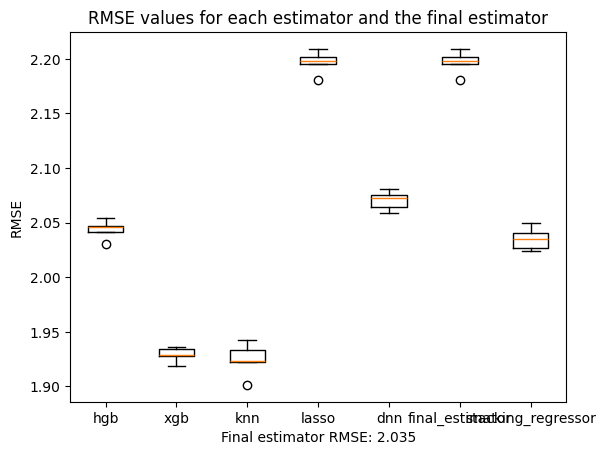

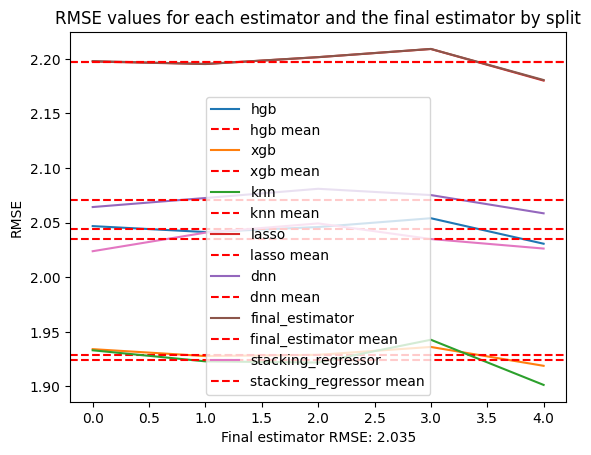

In [9]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [10]:
import numpy as np
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)
y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

5269/5269 - 3s - 532us/step - loss: 5.1065 - rmse: 4.0085
4215/4215 - 3s - 745us/step - loss: 4.7941 - rmse: 3.9930
1054/1054 - 1s - 688us/step
4215/4215 - 3s - 726us/step - loss: 5.2962 - rmse: 3.9390
1054/1054 - 1s - 702us/step
4215/4215 - 3s - 671us/step - loss: 5.3318 - rmse: 4.0941
1054/1054 - 1s - 698us/step
4215/4215 - 3s - 753us/step - loss: 5.1943 - rmse: 4.0836
1054/1054 - 1s - 660us/step
4215/4215 - 3s - 680us/step - loss: 4.9253 - rmse: 3.9297
1054/1054 - 1s - 703us/step
114/114 - 0s - 1ms/step


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.798887
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,5.964031
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.536542
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.414094
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.178514


In [11]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.798887
p01_8460,5.964031
p01_8461,7.536542
p01_8462,11.414094
p01_8463,7.178514
...,...
p24_256,6.367271
p24_257,11.607791
p24_258,6.503335


In [12]:
submission.to_csv(f'submission-model-{model_name}.csv')

In [13]:
y_pred = model.predict(X_train)

root_mean_squared_error(y_train, y_pred)


5269/5269 - 3s - 514us/step


np.float64(2.0095319041015514)

In [14]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_train, y_pred)

np.float64(2.0095319041015514)